# <font color='blue'>  Prior: </font>
We created an **image dataset** to get the reflectance and illuminant prior distributions. It has images of green fabric pieces on pots and Macbeth colorChecker charts. They were illuminated using an illuminant close to D65 standard. <br/>

$$P(R_k)= \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi \tau_k^2}}  exp⁡\biggl(-\frac{(r_ki-\mu_k)^2}{2\tau_k^2}\biggr)$$ <br/>
As the illumation is uniform over a pixel class the probability distribution is given by:
$$p(L_k)= u_k$$ <br/>


### Import &rarr; Python modules
The Bayesian color correction program needs multiple Python modules to run properly

In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

### Import &rarr; User modules
We created our own modules to organize the code and follow the object oriented programming philosophy

In [2]:
import plotting
import colorBayes
import checkerCards

### Variable declaration 
Define the Experiment & camera ID details

In [3]:
expID = 'cloth'
cam = 'cam03'
checker_angle = 0
colrLable = ['blu', 'grn', 'red']

### Directories 
Define the folder paths where is located the green fabric dataset

In [4]:
dirCurrent = os.getcwd()
dirParent = os.path.abspath(os.path.join(dirCurrent, os.pardir)) 
root            = os.path.join(dirParent, expID)
folder_images   = os.path.join(root, expID + '_' + 'imgPrior')
coor_path       = os.path.join(root, expID + '_coord_' + cam + '.csv')
colrCard_path   = os.path.join(root, '24ColorCard' + '.csv')
prior_path      = os.path.join(root, expID + "_csvPrior")
path_potTempl = os.path.join(root, 'potTempl.png')
print(path_potTempl)
if not os.path.exists(prior_path): os.makedirs(prior_path)

C:\Users\Diego Lozano\OneDrive - LA TROBE UNIVERSITY\PhD - GitHub\cloth\potTempl.png


### Read files & set Variables
Parameters for the image prespective and lens

In [5]:
list_images = [x for x in os.listdir(folder_images) if (x[-3:])=="png"]
coor_df = pd.read_csv(coor_path)
coor_df['col_centre'] = (coor_df.loc[:, "left"] + (coor_df.loc[:, "width"]/2)).values
coor_df['row_centre'] = (coor_df.loc[:, "top"] + (coor_df.loc[:, "height"]/2)).values
colorChecker = pd.read_csv(colrCard_path)
colorChecker = checkerCards.addXYZ(colorChecker)
potTemp = cv2.imread(path_potTempl)[:, :,0]


Load reference image

In [6]:
cnt = 0
imgName = list_images[cnt]
imgNumb = imgName.split(".")[0]
imgPath = os.path.join(folder_images, imgName)    
bgrSrc = cv2.imread(imgPath,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)    
sizSrc = bgrSrc.shape

### Illuminant from colorCheckers
Obtain the illuminant on colorCheckers from the reference image

In [7]:
_, illumChart0, colorTable = checkerCards.illum_check(colorChecker, coor_df, 
                                                    bgrSrc, checker_angle, 
                                                    colrLable, "original")


### Illuminant interpolation
 Perform a two-stage interpolation for the illuminant at the center of each pot

In [8]:
illumInterp0 = colorBayes.interp(coor_df, illumChart0, bgrSrc, imgNumb, colrLable)
illumInterp0 = checkerCards.addXYZ(illumInterp0)

### Illuminant surface
Create illuminant surface from the low resolution interpolation

In [9]:
illumSurf0 = colorBayes.illum_surface(illumInterp0, sizSrc, imgNumb, colrLable)

### Image color features
Obtain the distribution of pixel, reflectance and illuminant in the cloth pixel class

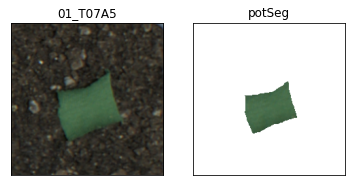

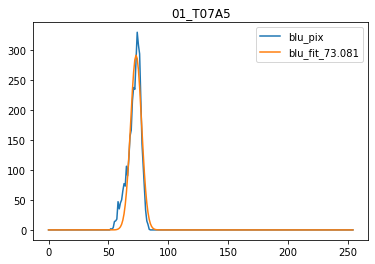

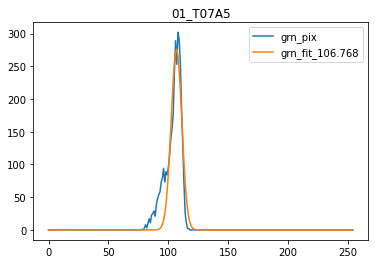

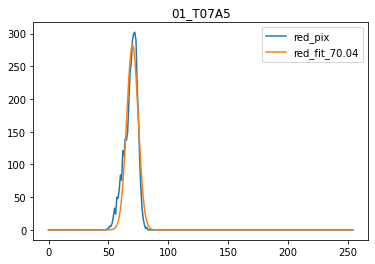

In [10]:
df_pix0, df_ill0, df_ref0 = colorBayes.imgFeature(bgrSrc, illumSurf0, coor_df, potTemp, imgNumb)

In [11]:
### Intensity off-set

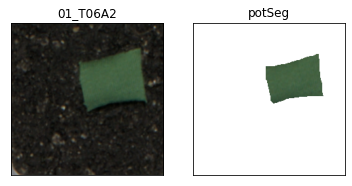

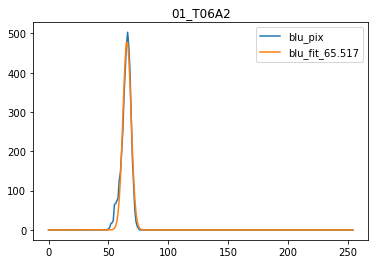

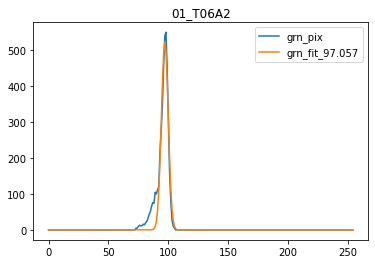

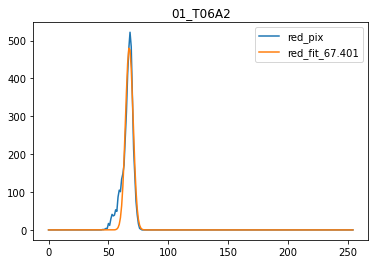

In [12]:
BGR_IllumCorr1 = colorBayes.correctIllumFit(bgrSrc, illumSurf0)     
_, illumChart1, _ = checkerCards.illum_check(colorChecker, coor_df, 
                                                    BGR_IllumCorr1, checker_angle, 
                                                    colrLable, "original")
illumChart1 = checkerCards.addXYZ(illumChart1)  
illumInterp1 = colorBayes.interp(coor_df, illumChart1, BGR_IllumCorr1, imgNumb, colrLable)
illumInterp1 = checkerCards.addXYZ(illumInterp1)
       
illumSurf1 = colorBayes.illum_surface(illumInterp1, sizSrc, imgNumb, colrLable)
df_pix1, df_ill1, df_ref1 = colorBayes.imgFeature(BGR_IllumCorr1, illumSurf1, coor_df, potTemp, imgNumb)

#%% 11. Calculate the pixel offset by substracting the mean 
blu_mean1 = np.mean(df_pix1.loc[:, ['blu']])
grn_mean1 = np.mean(df_pix1.loc[:, ['grn']])
red_mean1 = np.mean(df_pix1.loc[:, ['red']])

df_off_pix1 = df_pix1.loc[:, ['position', 'name', 'col_centre', 'row_centre']].copy()
df_off_pix1.loc[:, 'blu'] = df_pix1.loc[:, ['blu']] - blu_mean1
df_off_pix1.loc[:, 'grn'] = df_pix1.loc[:, ['grn']] - grn_mean1
df_off_pix1.loc[:, 'red'] = df_pix1.loc[:, ['red']] - red_mean1

  
pixelInterp1 = colorBayes.interp(coor_df, df_off_pix1, BGR_IllumCorr1, imgNumb, colrLable)
pixelInterp1 = checkerCards.addXYZ(pixelInterp1)


### Save files

In [13]:
illumInterp0.to_csv(os.path.join(root, 'prior' + '_' +  'Illum' + '_' + cam + '.csv'), index=False)
df_ref0.to_csv(os.path.join(root,  'prior' + '_' +  'refle' + '_' + cam + '.csv'), index=False)
pixelInterp1.to_csv(os.path.join(root,  'prior' + '_' +  'offset' + '_' + cam + '.csv'), index=False)